In [1]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 부모 디렉토리 추가 및 커스텀 모듈 임포트
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from multilayer_model.m3_hierarchical import HierarchicalCVAE3
from multilayer_loss.l_multi3_hierarchical import l_multi3_hierarchical, l_multi3_bce_hierarchical
from vae_earlystopping import EarlyStopping

In [2]:
# 1. 데이터 로드 (사용자 지정 경로 및 파일명 반영)
try:
    x1_data = np.load('../data/metal.npy')             # Phase 1: Metal
    x2_data = np.load('../data/support_norm.npy')      # Phase 2: Support
    x3_data = np.load('../data/pre_fin.npy')      # Phase 3: Pretreatment
    c_data = np.load('../data/re_fin.npy')             # Condition: Reaction/Active
    print("✅ All 3-Phase data loaded successfully.")
except FileNotFoundError as e:
    print(f"❌ Error loading data: {e}")

# 2. 데이터 분할 (Train/Val/Test) - 인덱스 일관성 유지
indices = np.arange(len(x1_data))
train_idx, temp_idx = train_test_split(indices, test_size=0.4, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

def split_and_scale(data, train_idx, val_idx, test_idx, scale=True):
    train, val, test = data[train_idx], data[val_idx], data[test_idx]
    if scale:
        scaler = MinMaxScaler()
        train = scaler.fit_transform(train)
        val = scaler.transform(val)
        test = scaler.transform(test)
        return train, val, test, scaler
    return train, val, test, None

x1_train, x1_val, x1_test, _ = split_and_scale(x1_data, train_idx, val_idx, test_idx)
x2_train, x2_val, x2_test, _ = split_and_scale(x2_data, train_idx, val_idx, test_idx)
x3_train, x3_val, x3_test, _ = split_and_scale(x3_data, train_idx, val_idx, test_idx)
c_train, c_val, c_test, c_scaler = split_and_scale(c_data, train_idx, val_idx, test_idx)

# 3. 텐서 변환 및 데이터로더
def to_t(arr): return torch.tensor(arr, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(to_t(x1_train), to_t(x2_train), to_t(x3_train), to_t(c_train)), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(to_t(x1_val), to_t(x2_val), to_t(x3_val), to_t(c_val)), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(to_t(x1_test), to_t(x2_test), to_t(x3_test), to_t(c_test)), batch_size=64, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

✅ All 3-Phase data loaded successfully.
Using device: cuda


In [3]:
# 4. 3단계 계층 모델 초기화
x_dims = [x1_train.shape[1], x2_train.shape[1], x3_train.shape[1]]
c_dim = c_train.shape[1]
z_dims = [16, 8, 4] # Metal -> Support -> Pretreatment 순으로 latent 압축

model = HierarchicalCVAE3(x_dims, c_dim, z_dims).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
es = EarlyStopping(patience=50, min_delta=1e-7)

In [4]:
# 5. 학습 루프 (KL Annealing 적용)
epochs = 500
total_anneal_steps = 150 # 150에폭 동안 KL 가중치를 서서히 증가

for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for b1, b2, b3, bc in train_loader:
        b1, b2, b3, bc = b1.to(device), b2.to(device), b3.to(device), bc.to(device)
        
        optimizer.zero_grad()
        out = model(b1, b2, b3, bc)
        
        # 3단계 계층적 Loss 계산 (BCE for Metal, MSE for others)
        # 여기서는 복합적인 학습을 위해 수치 복원(MSE) 위주로 구성된 l_multi3_hierarchical 사용
        # 실제 금속 존재 여부가 중요하면 l_multi3_bce_hierarchical로 교체 가능
        loss_results = l_multi3_hierarchical(
            out['x2_hat'], b2, # 메인 타겟 예시 (Support)
            out['mu_list'], out['lv_list'],
            gamma_list=[0.1, 0.05, 0.02], # NVAE 기반 가중치 차등
            step=epoch,
            total_steps=total_anneal_steps
        )
        
        loss = loss_results['loss']
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation
    model.eval()
    v_loss = 0
    with torch.no_grad():
        for v1, v2, v3, vc in val_loader:
            v1, v2, v3, vc = v1.to(device), v2.to(device), v3.to(device), vc.to(device)
            vout = model(v1, v2, v3, vc)
            v_loss += l_multi3_hierarchical(
                vout['x2_hat'], v2, vout['mu_list'], vout['lv_list'],
                step=epoch, total_steps=total_anneal_steps
            )['loss'].item()
            
    avg_v_loss = v_loss / len(val_loader)
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{epochs} | V_Loss: {avg_v_loss:.6f} | Anneal_W: {loss_results['anneal_w']:.2f}")
    
    if es(avg_v_loss, model):
        print(f"Early stopping at epoch {epoch}")
        break

es.load_best_model(model)

EarlyStopping counter: 1 out of 50
EarlyStopping counter: 1 out of 50
EarlyStopping counter: 2 out of 50
EarlyStopping counter: 3 out of 50
EarlyStopping counter: 4 out of 50
Epoch 20/500 | V_Loss: 0.024676 | Anneal_W: 0.13
EarlyStopping counter: 1 out of 50
EarlyStopping counter: 2 out of 50
EarlyStopping counter: 3 out of 50
EarlyStopping counter: 1 out of 50
EarlyStopping counter: 2 out of 50
EarlyStopping counter: 3 out of 50
EarlyStopping counter: 4 out of 50
EarlyStopping counter: 5 out of 50
EarlyStopping counter: 6 out of 50
EarlyStopping counter: 7 out of 50
EarlyStopping counter: 8 out of 50
EarlyStopping counter: 9 out of 50
EarlyStopping counter: 10 out of 50
EarlyStopping counter: 11 out of 50
EarlyStopping counter: 12 out of 50
EarlyStopping counter: 13 out of 50
EarlyStopping counter: 14 out of 50
Epoch 40/500 | V_Loss: 0.027185 | Anneal_W: 0.27
EarlyStopping counter: 15 out of 50
EarlyStopping counter: 16 out of 50
EarlyStopping counter: 17 out of 50
EarlyStopping count

In [8]:
# 6. 생성 능력 검증 (Inference)
print("\n--- Generating New Catalyst Recipes ---")
model.eval()
with torch.no_grad():
    # 수정 부분: numpy 배열을 torch tensor로 변환 후 device로 이동
    sample_c = torch.tensor(c_test[0:1], dtype=torch.float32).to(device)
    
    # 모델의 sample 메서드 호출
    m_prob, s_hat, p_hat = model.sample(sample_c, num_samples=1, device=device)
    
    print("Generated Metal Presence (Prob):\n", m_prob.cpu().numpy())
    print("Generated Support Composition:\n", s_hat.cpu().numpy())
    print("Generated Pretreatment Parameters:\n", p_hat.cpu().numpy())

# 결과 저장
torch.save(model.state_dict(), '../model/h_cvae_3phase_best.pth')
print("\n✅ Best model saved to model/h_cvae_3phase_best.pth")


--- Generating New Catalyst Recipes ---
Generated Metal Presence (Prob):
 [[0.509441   0.45807338 0.4825478  0.5463639  0.5583749  0.4581282
  0.456948   0.5294204  0.45123148 0.4564455  0.5061006  0.4562584
  0.50770235 0.5065895  0.48874614 0.5183054  0.5437743  0.5497697
  0.5314786  0.47371042 0.48374766 0.4691635  0.5001851 ]]
Generated Support Composition:
 [[0.9098881  0.9574045  1.0243844  0.9938602  1.0013671  0.99899656
  0.92017823 1.0291219  0.89317936 1.0184745  0.9339889  0.34356856
  0.8011177  1.0645435  0.06514156 0.8909368  0.85040444 0.9459517
  1.0046573  0.94741845 0.999928   1.0985283  0.2576965  0.9707503
  1.0080433  0.26100448 0.1225142  1.0279918  1.0089365  0.18131079
  0.29240444 0.63765764 0.04172555 0.66989607 0.8196201  0.8191382
  0.5937754  1.0116295  0.6787492  1.033002   0.9829287  0.6483387
  1.0095894  0.9788791  1.043968  ]]
Generated Pretreatment Parameters:
 [[-0.0725898   0.10600795 -0.08856764  0.06289817 -0.04320722]]

✅ Best model saved to m


--- Comprehensive Generation Verification ---
📊 [Metric] Reconstruction R2 Score (Support): -35.7364
✅ [Metric] Generation Feasibility Rate: 0.00%


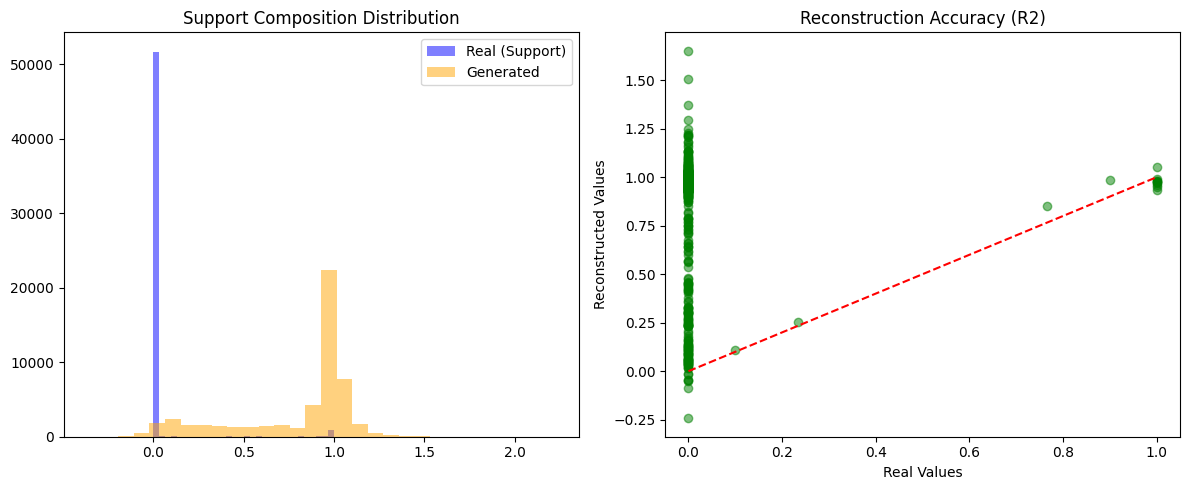


✅ Verification report saved to model/generation_report.json


In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# 6. 생성 능력 및 공학적 타당성 검증 (Verification)
print("\n--- Comprehensive Generation Verification ---")
model.eval()

with torch.no_grad():
    # 1. 테스트셋 전체에 대해 생성 수행
    x1_test_t = torch.tensor(x1_test, dtype=torch.float32).to(device)
    x2_test_t = torch.tensor(x2_test, dtype=torch.float32).to(device)
    x3_test_t = torch.tensor(x3_test, dtype=torch.float32).to(device)
    c_test_t = torch.tensor(c_test, dtype=torch.float32).to(device)
    
    # Reconstruction 결과 (복원력 확인)
    out = model(x1_test_t, x2_test_t, x3_test_t, c_test_t)
    x2_recon = out['x2_hat'].cpu().numpy()
    
    # Pure Generation 결과 (조건 c만으로 생성)
    m_prob, s_gen, p_gen = model.sample(c_test_t, num_samples=len(c_test), device=device)
    s_gen = s_gen.cpu().numpy()
    p_gen = p_gen.cpu().numpy()

# --- 지표 1: Reconstruction R2 Score ---
# 모델이 기존 데이터를 얼마나 정확하게 재현하는지 측정
r2_val = r2_score(x2_test.flatten(), x2_recon.flatten())
print(f"📊 [Metric] Reconstruction R2 Score (Support): {r2_val:.4f}")

# --- 지표 2: Catalyst Feasibility (공학적 타당성) ---
# 생성된 지지체 함량(s_gen)의 합이 논리적 범위(예: 0.1~1.5) 내에 있는지 확인
# DRM 촉매 특성에 따라 범위를 조정하세요.
s_sum = np.sum(s_gen, axis=1)
feasibility_rate = np.mean((s_sum > 0.05) & (s_sum < 2.0)) * 100
print(f"✅ [Metric] Generation Feasibility Rate: {feasibility_rate:.2f}%")

# --- 지표 3: Distribution Comparison (시각적 검증) ---
# 실제 데이터와 생성된 데이터의 분포가 유사한지 히스토그램으로 확인
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(x2_test.flatten(), bins=30, alpha=0.5, label='Real (Support)', color='blue')
plt.hist(s_gen.flatten(), bins=30, alpha=0.5, label='Generated', color='orange')
plt.title("Support Composition Distribution")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(x2_test.flatten()[:500], x2_recon.flatten()[:500], alpha=0.5, color='green')
plt.plot([0, 1], [0, 1], 'r--') # 기준선
plt.xlabel("Real Values")
plt.ylabel("Reconstructed Values")
plt.title("Reconstruction Accuracy (R2)")

plt.tight_layout()
plt.show()

# 결과 저장
results = {
    "r2_score": float(r2_val),
    "feasibility_rate": float(feasibility_rate)
}
with open('../model/generation_report.json', 'w') as f:
    json.dump(results, f, indent=4)
print("\n✅ Verification report saved to model/generation_report.json")